In [2]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [3]:
# set up the engine
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [6]:
#get all films which were rented in May 2005:
query1 = '''SELECT DISTINCT f.title AS film_title
FROM sakila.film f 
LEFT JOIN sakila.inventory i 
USING (film_id)
LEFT JOIN sakila.rental r 
USING (inventory_id)
WHERE r.rental_date LIKE '2005-05%%';'''

data1 = pd.read_sql_query(query1, engine)
data1.head()

,film_title
0,BLANKET BEVERLY
1,FREAKY POCUS
2,GRADUATE LORD
3,LOVE SUICIDES
4,IDOLS SNATCHERS


In [8]:
#get all films with the features to analyze
query2 = '''SELECT DISTINCT f.film_id, f.title, f.length, c.name, f.rental_duration, f.rental_rate
FROM sakila.film f
LEFT JOIN sakila.film_category fica 
ON f.film_id = fica.film_id
LEFT JOIN sakila.category c 
USING (category_id);'''

data2 = pd.read_sql_query(query2, engine)
data2.head()

,film_id,title,length,name,rental_duration,rental_rate
0,1,ACADEMY DINOSAUR,86,Documentary,6,0.99
1,2,ACE GOLDFINGER,48,Horror,3,4.99
2,3,ADAPTATION HOLES,50,Documentary,7,2.99
3,4,AFFAIR PREJUDICE,117,Horror,5,2.99
4,5,AFRICAN EGG,130,Family,6,2.99


In [10]:
#Create new column in data2 if film was rented in may
import numpy as np
data2['rented_in_may'] = np.where(data2['title'].isin(data1['film_title']) ,1,0)
data2

,film_id,title,length,name,rental_duration,rental_rate,rented_in_may
0,1,ACADEMY DINOSAUR,86,Documentary,6,0.99,1
1,2,ACE GOLDFINGER,48,Horror,3,4.99,0
2,3,ADAPTATION HOLES,50,Documentary,7,2.99,1
3,4,AFFAIR PREJUDICE,117,Horror,5,2.99,1
4,5,AFRICAN EGG,130,Family,6,2.99,1
...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,183,Documentary,6,0.99,0
996,997,YOUTH KICK,179,Music,4,0.99,0
997,998,ZHIVAGO CORE,105,Horror,6,0.99,1
998,999,ZOOLANDER FICTION,101,Children,5,2.99,1


In [19]:
#dropping film_id
data2 = data2.drop('film_id', axis=1)

In [20]:
#Checking the data types of the columns
data2.dtypes

title               object
length               int64
name                object
rental_duration      int64
rental_rate        float64
rented_in_may        int32
dtype: object

In [21]:
#Checking for NaN values
data2.isna().sum()

title              0
length             0
name               0
rental_duration    0
rental_rate        0
rented_in_may      0
dtype: int64

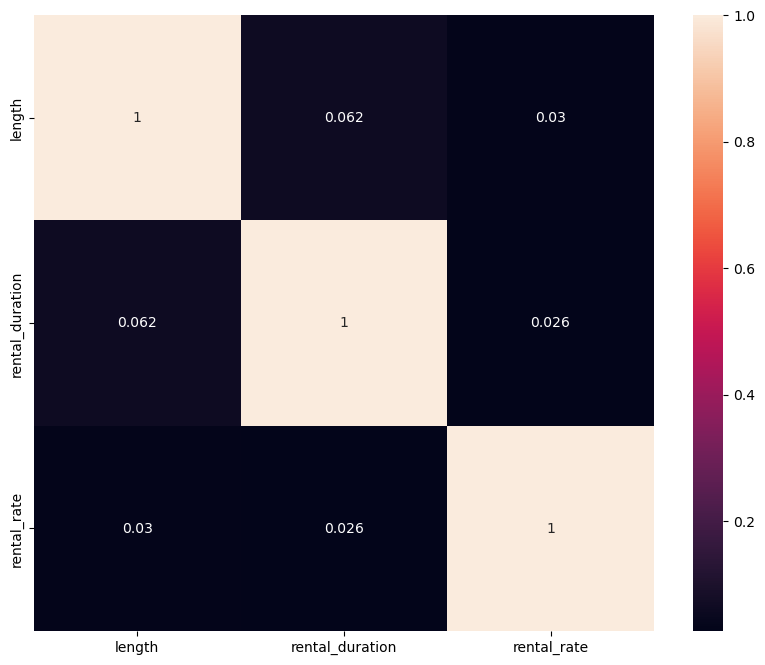

In [22]:
#Checking multicollinearity for the numerical features
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix=data2.drop('rented_in_may', axis=1).corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [27]:
# Need to X-y-split AND train-test-split BEFORE I apply transformations, 
# then train transformation on training set only
y = data2['rented_in_may']
X = data2.drop(['rented_in_may', 'title'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns = X_train_num.columns)
X_train_norm

,length,rental_duration,rental_rate
0,0.690647,0.50,0.0
1,0.705036,0.25,0.0
2,0.453237,1.00,0.5
3,0.251799,0.75,0.5
4,0.712230,0.50,1.0
...,...,...,...
795,0.273381,0.50,0.5
796,0.928058,0.25,1.0
797,0.438849,0.00,0.5
798,0.230216,1.00,1.0


In [30]:
# OneHot Encoder for categoricals
from sklearn.preprocessing import OneHotEncoder

X_train_cat = X_train.select_dtypes(include = np.object)
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
all_columns = encoder.get_feature_names_out(input_features=X_train_cat.columns)
encoded = pd.DataFrame(encoder.transform(X_train_cat).toarray(), columns=all_columns)
encoded.head()

C:\Users\lisab\AppData\Local\Temp\ipykernel_19524\696303164.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_cat = X_train.select_dtypes(include = np.object)


,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
# build X_train and y_train
# remember: y = data['status'], y_train selected in train_test_split
X_train_transformed = np.concatenate([X_train_norm, encoded], axis=1)

array([[0.69064748, 0.5       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.70503597, 0.25      , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.45323741, 1.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.43884892, 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.23021583, 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28057554, 0.75      , 0.5       , ..., 0.        , 0.        ,
        0.        ]])

In [32]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [33]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized, columns=X_test_num.columns)
X_test_norm

,length,rental_duration,rental_rate
0,0.712230,0.25,1.0
1,0.568345,0.50,0.5
2,0.848921,0.00,1.0
3,0.266187,1.00,0.0
4,0.402878,0.00,0.0
...,...,...,...
195,0.985612,1.00,0.0
196,0.035971,0.50,1.0
197,0.424460,0.75,0.0
198,0.841727,0.00,1.0


In [34]:
# for categoricals
X_test_cat = X_test.select_dtypes(include = np.object)
#encoder = OneHotEncoder(drop='first').fit(X_train_cat)
all_columns_test = encoder.get_feature_names_out(input_features=X_test_cat.columns)
encoded_test = pd.DataFrame(encoder.transform(X_test_cat).toarray(), columns=all_columns_test)
encoded_test.head()

C:\Users\lisab\AppData\Local\Temp\ipykernel_19524\479248085.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_cat = X_test.select_dtypes(include = np.object)


,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [35]:
X_test_transformed = np.concatenate([X_test_norm, encoded_test], axis=1)

array([[0.71223022, 0.25      , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.56834532, 0.5       , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.84892086, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.42446043, 0.75      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.84172662, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.99280576, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [36]:
# Now we can make predictions on the test set:
predictions = classification.predict(X_test_transformed)
predictions
classification.score(X_test_transformed, y_test)

0.685

In [37]:
print(y_test.value_counts())

1    133
0     67
Name: rented_in_may, dtype: int64


In [38]:
pd.Series(predictions).value_counts()

1    194
0      6
dtype: int64

In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  5,  62],
       [  1, 132]], dtype=int64)

#### Conclusion: The classification score is 68.5%. The Logistic Regression was done with multi_class = multinomial. Will try in the next step to use the default value for multi_class (which is auto):

In [40]:
classification2 = LogisticRegression(solver='lbfgs').fit(X_train_transformed, y_train)
classification2

LogisticRegression()

In [41]:
predictions2 = classification2.predict(X_test_transformed)
classification2.score(X_test_transformed, y_test)

0.67

#### Conclusion: Not better, slightly worse.